# < 자동차 번호판 인식 토이프로젝트 >
- 자동차 번호판만 인식해서 박스표시를 할 수 있도록 실습 진행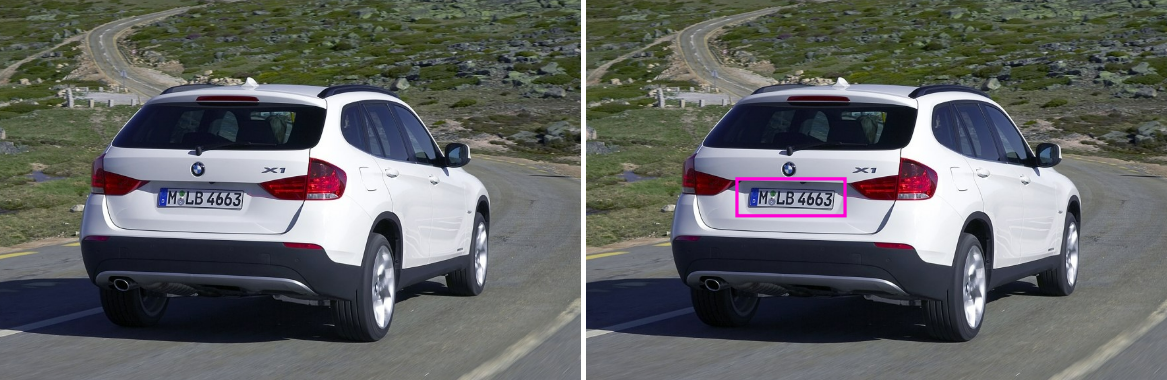

# 1. 차량 이미지 파일 읽기

In [2]:
pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


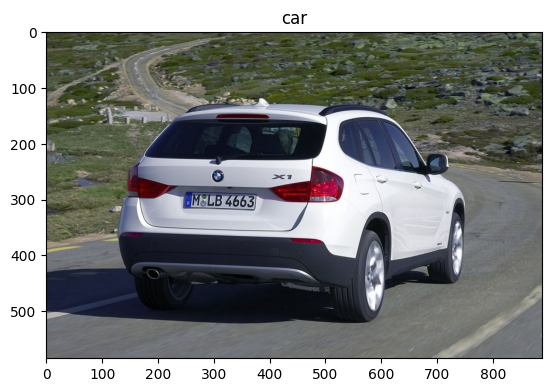

In [19]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytesseract 

image_path = "car_number.png"

#이미지 읽기
image = cv2.imread(image_path)

#RGB 컨버터(필수)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#이미지 형태
height, width, channel = image.shape

plt.imshow(image)
plt.title('car')
plt.show()

---

# 2. 차량 이미지 Grayscale 변환
차의 번호판을 인식하기 위해서는 명암 대비를 이용해야 합니다.

이러한 명암 대비를 위해서는 회색조 처리를 하면 더 효과적이에요!

그래서 우리는 미리 회색조 처리를 해줄겁니다.



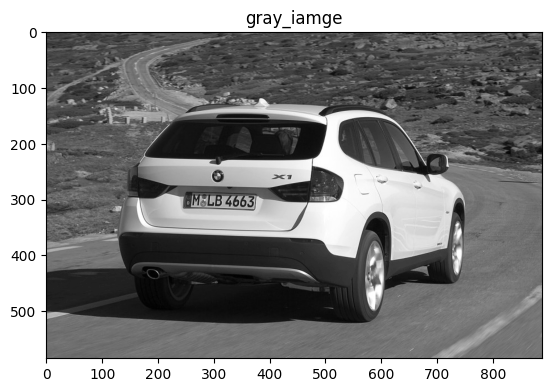

In [9]:
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

plt.imshow(gray_image, 'gray')
plt.title('gray_iamge')
plt.show()

---

# 3. 차량 이미지 콘트라스트(명암) 대비 극대화 : Maximize Contrast
콘트라스트 최대화는 가장 어두운 부분과 가장 밝은 부분의 차이를 높여 이미지의 선명도를 올려줍니다.

명암 대비를 극대화 시키는 작업으로 이해하셔도 좋습니다!


- Top Hat : 밝은 부분을 강조합니다.
- Black Hat : 어두운 부분을 강조합니다.


각각 밝고 어두운 부분을 강조하는 TopHat과 BlackHat을 이용해서 콘트라스트를 최대화 하겠습니다!



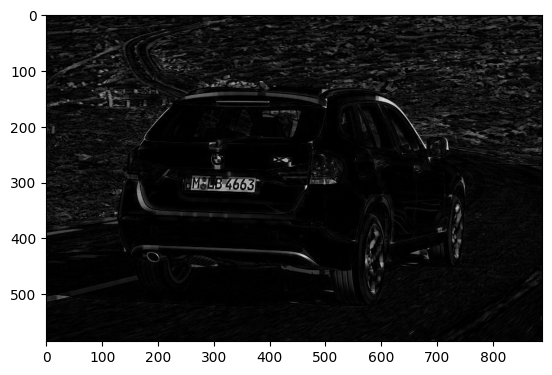

In [11]:
#모폴로지 연산
#9x9 직사각형 형태의 구조 요소 생성하여 structuring Element 변수에 할당
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))

#TOPHAT 
#밝기 값이 크게 변화하는 영역 강조
imgTopHat = cv2.morphologyEx(gray_image, cv2.MORPH_TOPHAT, structuringElement)

plt.imshow(imgTopHat, 'gray')
plt.show()

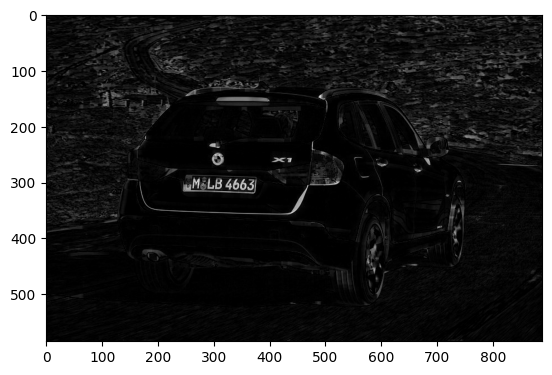

In [12]:
# BLACK HAT
# 어두운 부분 강조
imgBlackHat = cv2.morphologyEx(gray_image, cv2.MORPH_BLACKHAT, structuringElement)

plt.imshow(imgBlackHat, 'gray')
plt.show()

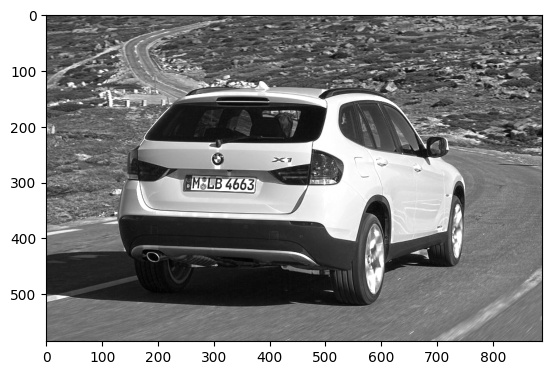

In [13]:
# 합치기
# 두 이미지의 같은 위치에 존재하는 픽셀값 더해서 결과 이미지의 픽셀 값으로 설정
imgGrayscalePlusTopHat = cv2.add(gray_image, imgTopHat)

plt.imshow(imgGrayscalePlusTopHat, 'gray')
plt.show()

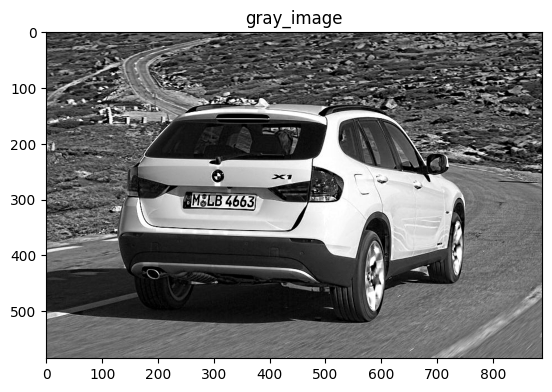

In [14]:
# 빼기
# 두 이미지 같은값 존재 픽셀을 결과 이미지 픽셀 값으로 설정
# 밸셈 결과가 0보다 작으면 픽셀값 9으로 설정 

gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

plt.imshow(gray, 'gray')
plt.title('gray_image')
plt.show()

---

# 4. 차량 이미지 이진화(Adaptive Thresholding)
﻿
가우시안 이진화를 통해, 차량 이미지 이진화를 진행하겠습니다.

Gaussian Adaptive Thresholding은 가중 평균값을 이용해 주변 픽셀에 더 큰 영향을 줍니다.

﻿

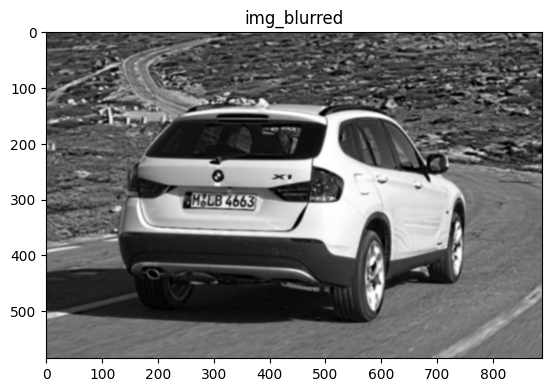

In [15]:
img_blurred = cv2.GaussianBlur(gray, ksize=(7,7), sigmaX=0)

plt.imshow(img_blurred, 'gray')
plt.title('img_blurred')
plt.show()

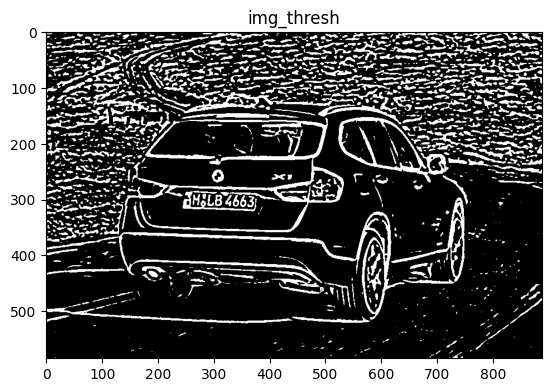

In [16]:
img_thresh = cv2.adaptiveThreshold(
    img_blurred,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=19,
    C=9
)

plt.imshow(img_thresh, 'gray')
plt.title('img_thresh')
plt.show()

---

# 5. 차량 이미지 Find Contour : 이미지에서 객체 외곽선 검출 

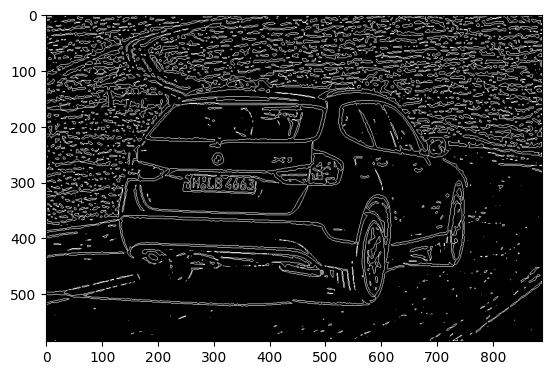

In [20]:
contours, hierarchy = cv2.findContours(
    img_thresh,
    mode = cv2.RETR_LIST,
    method = cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

# Contours 그리기
cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255,255,255))

plt.imshow(temp_result, 'gray')
plt.show()

# 6. 차량 이미지 전처리 (바운딩 박스 표시)
﻿이미지 내의 객체에 바운딩 박스를 표시하겠습니다.

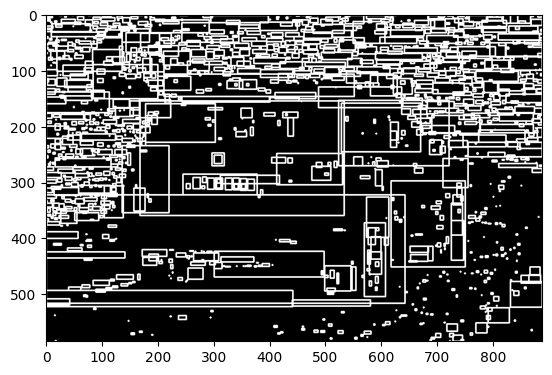

In [22]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
  x, y, w, h = cv2.boundingRect(contour)
  cv2.rectangle(temp_result, pt1=(x,y), pt2=(x+w, y+h), color=(255,255,255), thickness=2)

  # insert to dict
  contours_dict.append({
      'contour': contour,
      'x' : x,
      'y' : y,
      'w' : w,
      'h' : h,
      'cx': x + (w / 2),
      'cy': y + (h / 2)
  })

plt.imshow(temp_result, 'gray')
plt.show()

# 7. 번호판 후보 박스 선택(1) - 문자의 크기에 따라
﻿
6번 과정을 통해 모든 객체에 박스가 그려졌는데요.

이 박스 중에 번호판이 있을 법한 박스를 추리는 후보 선발 과정을 거쳐야 합니다.


후보 선택 과정은 박스의 너비, 높이, 면적을 측정해서

기준값과 비교하고 그 값이 비슷하면 후보로 선택하는 방식을 적용합니다.

﻿

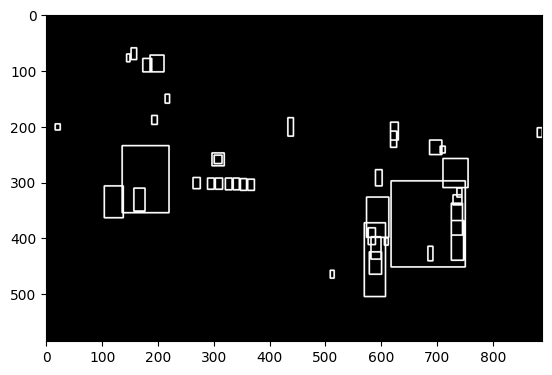

In [23]:
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []
cnt = 0

for d in contours_dict :
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']

    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO : 
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours : 
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255,255,255), thickness=2)

plt.imshow(temp_result, 'gray')
plt.show()

﻿과정을 진행하니, 많던 박스가 조건에 맞게 많이 추려지는 것을 볼 수 있습니다.

# 8. 번호판 후보 박스 선택(2) - 윤곽선의 배열에 따라


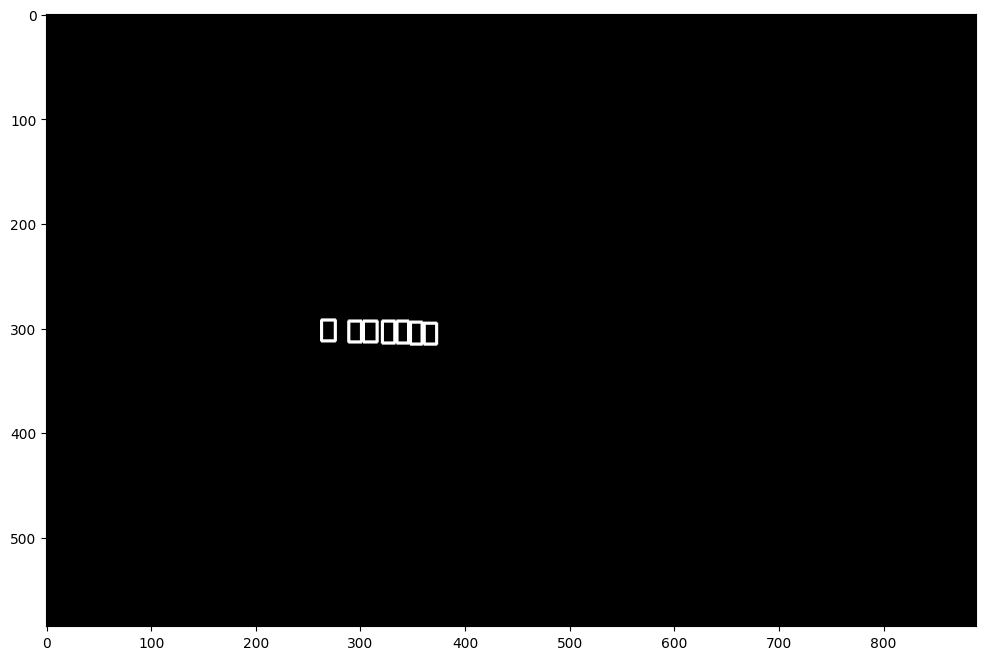

In [24]:
MAX_DIAG_MULTIPLYER = 5 
MAX_ANGLE_DIFF = 12.0 
MAX_AREA_DIFF = 0.5 
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3 

def find_chars(contour_list):
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, 
                                    unmatched_contour_idx)
        
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

temp_result = np.zeros(image.shape, dtype=np.uint8)

for r in matched_result:
    for d in r:

        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), 
                      pt2=(d['x']+d['w'], d['y']+d['h']), 
                      color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

# 9. 차량 번호판 회전 : 수평 맞추기
﻿
번호판이 무조건 수평인 모양으로 사진이 찍히는 것은 아니기 때문에,

번호판 모양을 수평으로 맞춰주는 이미지 회전 작업을 진행해야 합니다.

﻿

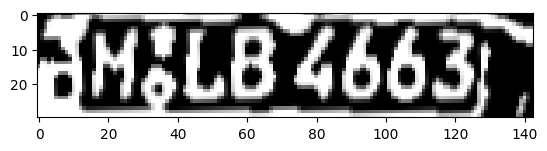

In [27]:
PLATE_WIDTH_PADDING = 1.3
PLATE_HEIGHT_PADDING = 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
  sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

  plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
  plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2

  plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w']-sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
  
  sum_height = 0
  for d in sorted_chars:
    sum_height += d['h']

  plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)

  triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
  triangle_hypotenus = np.linalg.norm(
      np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) -
      np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
  )

angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))

rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)

img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))

img_cropped = cv2.getRectSubPix(
    img_rotated,
    patchSize=(int(plate_width), int(plate_height)),
    center=(int(plate_cx), int(plate_cy))
)
plate_imgs.append(img_cropped)
plate_infos.append({
    'x': int(plate_cx - plate_width /2),
    'y': int(plate_cy - plate_height/2),
    'w': int(plate_width),
    'h': int(plate_height),
})

plt.imshow(img_cropped, 'gray')
plt.show()

---


# 11. 추가 이진화 작업
입력 이미지 주위에 픽셀값 또는 테두리를 추가하여

조금 더 숫자 부분만 보일 수 있도록 하는 이진화 작업을 해보겠습니다.

﻿

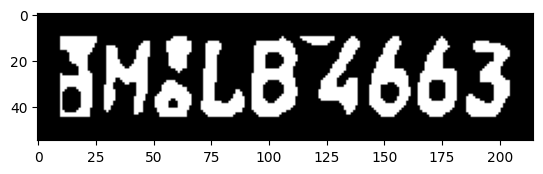

In [28]:
import cv2
import matplotlib.pyplot as plt

longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)  # Resizing original image by a factor of 1.6
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Find contours again (same as above)
    contours, hierarchy = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)

    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        area = w * h
        ratio = w / h

        if area > MIN_AREA and w > MIN_WIDTH and h > MIN_HEIGHT and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h

    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]

    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10,
                                    borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))

    plt.imshow(img_result, cmap='gray')  # Display the result
    plt.show()


---

# 12. 차량 번호판에 박스 표시

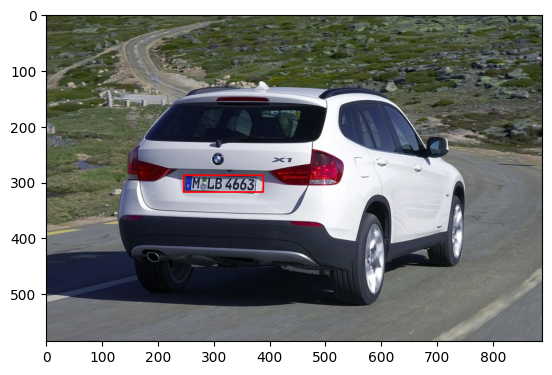

In [29]:
info = plate_infos[longest_idx]
img_out = image.copy()

cv2.rectangle(img_out, pt1=(info['x'], info['y']), pt2=(info['x']+info['w'], info['y']+info['h']),
              color=(255,0,0), thickness=2)

plt.imshow(img_out)
plt.show()